<a href="https://colab.research.google.com/github/IrynaTkachenko/ai-experience/blob/main/linearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge,Lasso,LassoCV
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_val_predict,TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

nomeArquivo = '/content/test.csv'
dataset = pd.read_csv(nomeArquivo,parse_dates=True)

pd.set_option('display.max_columns', None)
print(dataset.head())
print(dataset.columns)
print(dataset.info())

print(dataset.tail())

         Data Temperatura Media (C) Temperatura Minima (C)  \
0  2015-01-01                  27,3                   23,9   
1  2015-01-02                 27,02                   24,5   
2  2015-01-03                 24,82                   22,4   
3  2015-01-04                 23,98                   21,5   
4  2015-01-05                 23,82                     21   

  Temperatura Maxima (C) Precipitacao (mm)  Final de Semana  \
0                   32,5                 0              0.0   
1                   33,5                 0              0.0   
2                   29,9                 0              1.0   
3                   28,6               1,2              1.0   
4                   28,3                 0              0.0   

   Consumo de cerveja (litros)  
0                       25.461  
1                       28.972  
2                       30.814  
3                       29.799  
4                       28.900  
Index(['Data', 'Temperatura Media (C)', 'Temperatu

Text(0.5, 0.1, 'último: 2015-12-31')

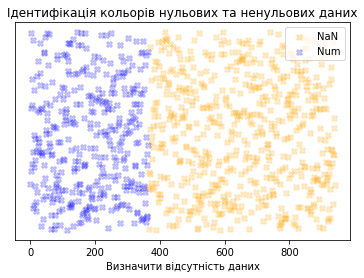

<Figure size 432x288 with 0 Axes>

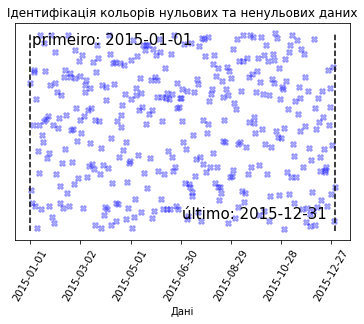

In [7]:
indicesNulos = dataset['Consumo de cerveja (litros)'].isna()
listaNaN = dataset[indicesNulos].index.tolist()
listaNum = dataset[~indicesNulos].index.tolist()

plt.figure(1)
plt.scatter(listaNaN,np.random.random(len(listaNaN))*2,marker='X',c='orange',alpha=0.2)
plt.scatter(listaNum,np.random.random(len(listaNum))*2,marker='X',c='b',alpha=0.2)
plt.xlabel('Визначити відсутність даних')
plt.legend(['NaN','Num'],loc='upper right')
plt.tick_params(axis='y',which='both',left=False,bottom=False,labelleft=False)
plt.title('Ідентифікація кольорів нульових та ненульових даних')

plt.figure(2)
fig,ax = plt.subplots(1,1)
plt.scatter(dataset.iloc[listaNum,0],np.random.random(len(listaNum))*2,marker='X',c='b',alpha=0.3)
primeiroRegistroNum = dataset.iloc[listaNum[0],0]
ultimoRegistroNum = dataset.iloc[listaNum[-1],0]
plt.plot([primeiroRegistroNum,primeiroRegistroNum],[0,2],c='black',linestyle='--')
plt.plot([ultimoRegistroNum,ultimoRegistroNum],[0,2],c='black',linestyle='--')
plt.xlabel('Дані')
plt.title('Ідентифікація кольорів нульових та ненульових даних')
plt.tick_params(axis='y',which='both',left=False,bottom=False,labelleft=False)
ax.xaxis.set_major_locator(MaxNLocator(8)) 
plt.tick_params(labelrotation=60)
ax.annotate('початок: {}'.format(dataset.iloc[listaNum[0],0]),xy=(0.05, 0.9), xycoords='axes fraction',fontsize=15)
ax.annotate('кінець: {}'.format(dataset.iloc[listaNum[-1],0]),xy=(0.50, 0.1), xycoords='axes fraction',fontsize=15)

In [13]:
dsPreprocessado = dataset
dsPreprocessado = dataset.dropna()

#dsPreprocessador = dsPreprocessado.replace(',','.',inplace=True,regex=True)
dsPreprocessado = dsPreprocessado.drop(columns='Data')

#dsPreprocessado.iloc[:,0:4] = dsPreprocessado.iloc[:,0:4].apply(pd.to_numeric)
dsPreprocessado.iloc[:,4] = dsPreprocessado.iloc[:,4].astype(int)# apply(pd.to_numeric(downcast='int'))
print(dsPreprocessado.info())

print(dsPreprocessado.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 0 to 364
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Temperatura Media (C)        365 non-null    object 
 1   Temperatura Minima (C)       365 non-null    object 
 2   Temperatura Maxima (C)       365 non-null    object 
 3   Precipitacao (mm)            365 non-null    object 
 4   Final de Semana              365 non-null    int64  
 5   Consumo de cerveja (litros)  365 non-null    float64
dtypes: float64(1), int64(1), object(4)
memory usage: 20.0+ KB
None
       Final de Semana  Consumo de cerveja (litros)
count       365.000000                   365.000000
mean          0.284932                    25.401367
std           0.452001                     4.399143
min           0.000000                    14.343000
25%           0.000000                    22.008000
50%           0.000000                    24.867000


<Figure size 432x288 with 0 Axes>

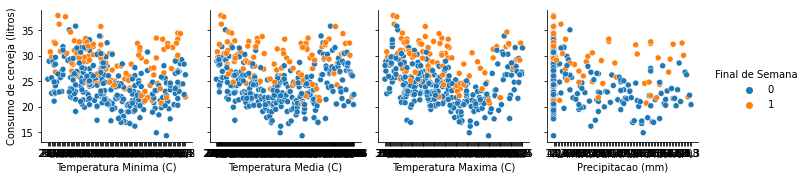

In [14]:
plt.figure(1)
sns.pairplot(dsPreprocessado,x_vars=['Temperatura Minima (C)','Temperatura Media (C)','Temperatura Maxima (C)','Precipitacao (mm)'],y_vars=['Consumo de cerveja (litros)'],hue='Final de Semana',diag_kind=None)

Text(0, 0.5, 'Consumo de cerveja [L]')

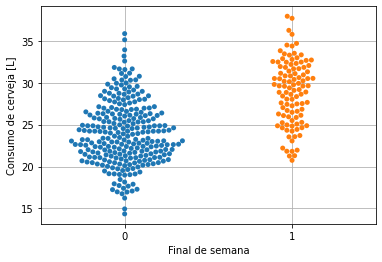

In [15]:
plt.figure(2)
sns.swarmplot(x='Final de Semana',y='Consumo de cerveja (litros)',data=dsPreprocessado)
plt.grid()
plt.xlabel('Final de semana')
plt.ylabel('Consumo de cerveja [L]')

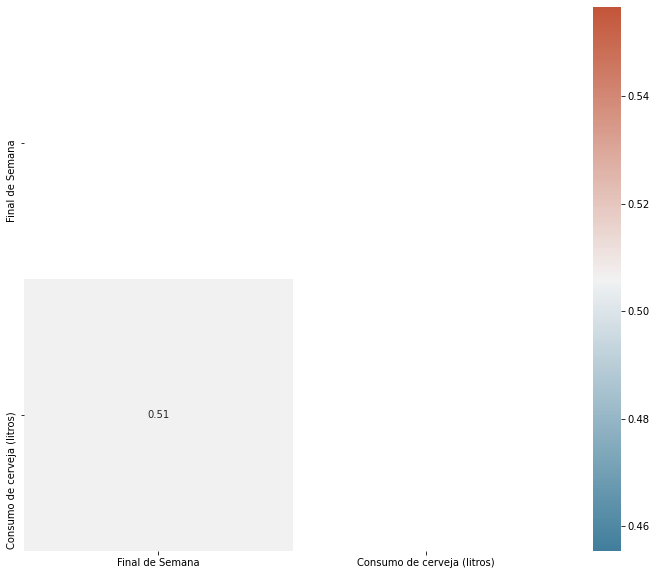

In [16]:
correlation = dsPreprocessado.corr()

f, ax = plt.subplots(figsize=(12, 10))

# Generate a mask for upper traingle

mask = np.triu(np.ones_like(correlation,dtype=bool))

# Configure a custom diverging colormap

cmap = sns.diverging_palette(230, 20, as_cmap=True)


sns.heatmap(correlation,cmap=cmap,mask=mask,annot=True)

In [20]:
reg = LinearRegression()
y = dsPreprocessado['Consumo de cerveja (litros)'].values #target
x = dsPreprocessado.drop(columns='Consumo de cerveja (litros)').values #fetures
xColunas = dsPreprocessado.drop(columns='Consumo de cerveja (litros)').columns
xTrain,xTest,yTrain,yTest = train_test_split(x,y,test_size=0.3,random_state=42)

reg.fit(xTrain,yTrain)
yPred = reg.predict(xTest)
res = yPred - yTest
avgRes = round(np.mean(res),3)
stdRes = round(np.std(res),3)


plt.figure(1)
plt.scatter(yPred,res)
plt.plot([min(yPred),max(yPred)],[avgRes,avgRes],linestyle='--',c='red')
plt.xlabel('Valor previsto')
plt.ylabel('Erro residual')
plt.text(17.5,4,'média = {} \nstd = {}'.format(avgRes,stdRes))

ValueError: ignored

In [22]:
#função para calcular R2 ajustado
def calculaR2ajustado(r2Score,x):
  n = np.shape(x)[0]
  k = np.shape(x)[1]
  return 1 - (1-r2Score)*(n-1)/(n-k-1)

print('Valor de R2: {}'.format(reg.score(xTest,yTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTest,yPred)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(reg.score(xTest,yTest),xTest)))
print('Coeficientes da regressão: {}'.format(reg.coef_))
print('Intercept da regressão: {} \n'.format(reg.intercept_))

NotFittedError: ignored

In [23]:
vif = [variance_inflation_factor(xTrain, i) for i in range(xTrain.shape[1])]
for v, c in zip(vif,xColunas):
  print('VIF de {} : {}'.format(c,v))

TypeError: ignored

In [24]:
dsTMaxMin  = dsPreprocessado.drop(columns='Temperatura Media (C)')
dsTMedia = dsPreprocessado.drop(columns=['Temperatura Maxima (C)','Temperatura Minima (C)'])
dsTMax = dsPreprocessado.drop(columns=['Temperatura Media (C)','Temperatura Minima (C)'])
dsTMin = dsPreprocessado.drop(columns=['Temperatura Media (C)','Temperatura Maxima (C)'])
dsTMediaMax = dsPreprocessado.drop(columns=['Temperatura Minima (C)'])
dsTMediaMin = dsPreprocessado.drop(columns=['Temperatura Maxima (C)'])

yTMaxMin = dsTMaxMin['Consumo de cerveja (litros)'].values
xTMaxMin = dsTMaxMin.drop(columns='Consumo de cerveja (litros)').values

yTMedia = dsTMedia['Consumo de cerveja (litros)'].values
xTMedia = dsTMedia.drop(columns='Consumo de cerveja (litros)').values

yTMediaMax = dsTMediaMax['Consumo de cerveja (litros)'].values
xTMediaMax = dsTMediaMax.drop(columns='Consumo de cerveja (litros)').values

yTMediaMin = dsTMediaMin['Consumo de cerveja (litros)'].values
xTMediaMin = dsTMediaMin.drop(columns='Consumo de cerveja (litros)').values

yTMedia = dsTMedia['Consumo de cerveja (litros)'].values
xTMedia = dsTMedia.drop(columns='Consumo de cerveja (litros)').values

yTMax = dsTMax['Consumo de cerveja (litros)'].values
xTMax = dsTMax.drop(columns='Consumo de cerveja (litros)').values

yTMin = dsTMin['Consumo de cerveja (litros)'].values
xTMin = dsTMin.drop(columns='Consumo de cerveja (litros)').values

In [26]:
xTMaxMinTrain,xTMaxMinTest,yTMaxMinTrain,yTMaxMinTest = train_test_split(xTMaxMin,yTMaxMin,test_size=0.4,random_state=42)
regTMaxMin = LinearRegression()
regTMaxMin.fit(xTMaxMinTrain,yTMaxMinTrain)
yTMaxMinPred = regTMaxMin.predict(xTMaxMinTest)
resTMaxMin = yTMaxMinPred - yTMaxMinTest
avgResTMaxMin = round(np.mean(resTMaxMin),3)
stdResTMaxMin = round(np.std(resTMaxMin),3)
vifTMaxMin = [variance_inflation_factor(xTMaxMinTrain, i) for i in range(xTMaxMinTrain.shape[1])]

print('--- TMaxMin ---')
print('Valor de R2: {}'.format(regTMaxMin.score(xTMaxMinTest,yTMaxMinTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMaxMin.score(xTMaxMinTest,yTMaxMinTest),xTMaxMinTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMaxMinTest,yTMaxMinPred)))
print('Coeficientes da regressão: {}'.format(regTMaxMin.coef_))
print('Intercept da regressão: {}'.format(regTMaxMin.intercept_))
print('VIF : {}\n'.format(vifTMaxMin))
print('* * * * * *\n')


xTMediaTrain,xTMediaTest,yTMediaTrain,yTMediaTest = train_test_split(xTMedia,yTMedia,test_size=0.4,random_state=42)
regTMedia = LinearRegression()
regTMedia.fit(xTMediaTrain,yTMediaTrain)
yTMediaPred = regTMedia.predict(xTMediaTest)
resTMedia = yTMediaPred - yTMediaTest
avgResTMedia = round(np.mean(resTMedia),3)
stdResTMedia = round(np.std(resTMedia),3)
vifTMedia = [variance_inflation_factor(xTMediaTrain, i) for i in range(xTMediaTrain.shape[1])]



print('--- TMedia ---')
print('Valor de R2: {}'.format(regTMedia.score(xTMediaTest,yTMediaTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMedia.score(xTMediaTest,yTMediaTest),xTMediaTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMediaTest,yTMediaPred)))
print('Coeficientes da regressão: {}'.format(regTMedia.coef_))
print('Intercept da regressão: {}'.format(regTMedia.intercept_))
print('VIF : {}\n'.format(vifTMedia))
print('* * * * * *\n')

xTMediaMaxTrain,xTMediaMaxTest,yTMediaMaxTrain,yTMediaMaxTest = train_test_split(xTMediaMax,yTMediaMax,test_size=0.4,random_state=42)
regTMediaMax = LinearRegression()
regTMediaMax.fit(xTMediaMaxTrain,yTMediaMaxTrain)
yTMediaMaxPred = regTMediaMax.predict(xTMediaMaxTest)
resTMediaMax = yTMediaMaxPred - yTMediaMaxTest
avgResTMediaMax = round(np.mean(resTMediaMax),3)
stdResTMediaMax = round(np.std(resTMediaMax),3)
vifTMediaMax = [variance_inflation_factor(xTMediaMaxTrain, i) for i in range(xTMediaMaxTrain.shape[1])]



print('--- TMediaMax ---')
print('Valor de R2: {}'.format(regTMediaMax.score(xTMediaMaxTest,yTMediaMaxTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMediaMax.score(xTMediaMaxTest,yTMediaMaxTest),xTMediaMaxTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMediaMaxTest,yTMediaMaxPred)))
print('Coeficientes da regressão: {}'.format(regTMediaMax.coef_))
print('Intercept da regressão: {}'.format(regTMediaMax.intercept_))
print('VIF : {}\n'.format(vifTMediaMax))
print('* * * * * *\n')

xTMediaMinTrain,xTMediaMinTest,yTMediaMinTrain,yTMediaMinTest = train_test_split(xTMediaMin,yTMediaMin,test_size=0.4,random_state=42)
regTMediaMin = LinearRegression()
regTMediaMin.fit(xTMediaMinTrain,yTMediaMinTrain)
yTMediaMinPred = regTMediaMin.predict(xTMediaMinTest)
resTMediaMin = yTMediaMinPred - yTMediaMinTest
avgResTMediaMin = round(np.mean(resTMediaMin),3)
stdResTMediaMin = round(np.std(resTMediaMin),3)
vifTMediaMin = [variance_inflation_factor(xTMediaMinTrain, i) for i in range(xTMediaMinTrain.shape[1])]



print('--- TMediaMin ---')
print('Valor de R2: {}'.format(regTMediaMin.score(xTMediaMinTest,yTMediaMinTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMediaMin.score(xTMediaMinTest,yTMediaMinTest),xTMediaMinTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMediaMinTest,yTMediaMinPred)))
print('Coeficientes da regressão: {}'.format(regTMediaMin.coef_))
print('Intercept da regressão: {}'.format(regTMediaMin.intercept_))
print('VIF : {}\n'.format(vifTMediaMin))
print('* * * * * *\n')


xTMaxTrain,xTMaxTest,yTMaxTrain,yTMaxTest = train_test_split(xTMax,yTMax,test_size=0.4,random_state=42)
regTMax = LinearRegression()
regTMax.fit(xTMaxTrain,yTMaxTrain)
yTMaxPred = regTMax.predict(xTMaxTest)
resTMax = yTMaxPred - yTMaxTest
avgResTMax = round(np.mean(resTMax),3)
stdResTMax = round(np.std(resTMax),3)
vifTMax = [variance_inflation_factor(xTMaxTrain, i) for i in range(xTMaxTrain.shape[1])]

print('--- TMax ---')
print('Valor de R2: {}'.format(regTMax.score(xTMaxTest,yTMaxTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMax.score(xTMaxTest,yTMaxTest),xTMaxTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMaxTest,yTMaxPred)))
print('Coeficientes da regressão: {}'.format(regTMax.coef_))
print('Intercept da regressão: {}'.format(regTMax.intercept_))
print('VIF : {}\n'.format(vifTMax))
print('* * * * * *\n')


xTMinTrain,xTMinTest,yTMinTrain,yTMinTest = train_test_split(xTMin,yTMin,test_size=0.4,random_state=42)
regTMin = LinearRegression()
regTMin.fit(xTMinTrain,yTMinTrain)
yTMinPred = regTMin.predict(xTMinTest)
resTMin = yTMinPred - yTMinTest
avgResTMin = round(np.mean(resTMin),3)
stdResTMin = round(np.std(resTMin),3)
vifTMin = [variance_inflation_factor(xTMinTrain, i) for i in range(xTMinTrain.shape[1])]

print('--- TMin ---')
print('Valor de R2: {}'.format(regTMin.score(xTMinTest,yTMinTest)))
print('Valor de R2 ajustado: {}'.format(calculaR2ajustado(regTMin.score(xTMinTest,yTMinTest),xTMinTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMinTest,yTMinPred)))
print('Coeficientes da regressão: {}'.format(regTMin.coef_))
print('Intercept da regressão: {}'.format(regTMin.intercept_))
print('VIF : {}\n'.format(vifTMin))
print('* * * * * *\n')


ValueError: ignored

Valores de R2 para validação cruzada: [nan nan nan nan nan nan]
Média de R2 para validação cruzada: nan
Std todos: nan


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '18,26'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '20,58'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '20,58'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score 

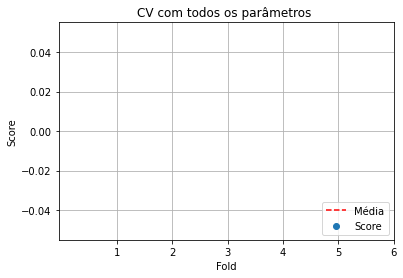

In [27]:
folds = 6
scores = cross_val_score(reg,xTrain,yTrain,cv=folds)
avgScores = np.mean(scores)

plt.scatter(list(range(1,folds+1)),scores)
plt.plot([1,folds],[avgScores,avgScores],linestyle='--',c='red')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(ticks=list(range(1,folds+1)))
plt.legend(['Média','Score'],loc='lower right')
plt.title('CV com todos os parâmetros ')
plt.grid()
print('Valores de R2 para validação cruzada: {}'.format(scores))
print('Média de R2 para validação cruzada: {}'.format(avgScores))
print('Std todos: {}'.format(np.std(scores)))

In [28]:
scoresTMax = cross_val_score(regTMax,xTMaxTrain,yTMaxTrain,cv=folds)
avgScoresTMax = np.mean(scoresTMax)
plt.scatter(list(range(1,folds+1)),scoresTMax)
plt.plot([1,folds],[avgScoresTMax,avgScoresTMax],linestyle='--',c='red')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(ticks=list(range(1,folds+1)))
plt.legend(['Média','Scores'],loc='upper right')
plt.title('CV com Temp. Máxima, precipitação e dia da semana ')
plt.grid()
print('Valores de R2 para validação cruzada: {}'.format(scoresTMax))
print('Média de R2 para validação cruzada: {}'.format(avgScoresTMax))
print('Std TMax: {}'.format(np.std(scoresTMax)))

NameError: ignored

In [29]:
scoresLasso = []
alphas = np.linspace(5e-4,2e-1,num=10000)

for a in alphas:
  regLasso = Lasso(alpha=a)
  regLasso.fit(xTrain,yTrain)
  yPredLasso = regLasso.predict(xTest)
  scoresLasso.append(regLasso.score(xTest,yTest))

plt.plot(alphas,scoresLasso)
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title(r'Variação de $R^2$ em função de $\alpha$')
plt.grid()

ValueError: ignored

In [30]:
alphasCV = np.linspace(5e-4,2e-1,num=10000)
paramGridLasso = {'alpha' : alphasCV,
              'normalize': [True,False]}
regLassoCV= GridSearchCV(Lasso(),cv=folds,param_grid= paramGridLasso)
regLassoCV.fit(xTrain,yTrain)
yPredRegLassoCV = regLassoCV.predict(xTest)
resLassoCV = yPredRegLassoCV - yTest
print('Valor de R2 Lasso: {}'.format(regLassoCV.score(xTest,yTest)))
print('Valor de R2 ajustado Lasso: {}'.format(calculaR2ajustado(regLassoCV.score(xTest,yTest),xTest)))
print('Valor MSE Lasso: {}' .format(mean_squared_error(yTest,yPredRegLassoCV)))
print('Coeficientes : {}'.format(regLassoCV.best_estimator_.coef_))
print('Intercept : {}'.format(regLassoCV.best_estimator_.intercept_))
print('Melhores parâmetros: {}'.format(regLassoCV.best_params_))

Показано результат, скорочений до останніх рядків (5000).
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '27,2'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '7,6'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: could not convert string to float: '27,2'

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:5

ValueError: ignored

In [31]:
resLassoCV = yPredRegLassoCV - yTest
avgResLassoCV = round(np.mean(resLassoCV),3)
stdResLassoCV = round(np.std(resLassoCV),3)

plt.scatter(yPredRegLassoCV,resLassoCV)
plt.plot([min(yPredRegLassoCV),max(yPredRegLassoCV)],[avgResLassoCV,avgResLassoCV],linestyle='--',c='red')
plt.title('Erro residual: Regressão Lasso')
plt.xlabel('Valor previsto')
plt.ylabel('Erro residual')
plt.text(16.8,4,'$\mu$ = {}\n$\sigma$ = {}'.format(avgResLassoCV,stdResLassoCV))

NameError: ignored

In [32]:
regTMaxCV= GridSearchCV(regTMax,cv=folds,param_grid={'normalize':[True,False]})
regTMaxCV.fit(xTMaxTrain,yTMaxTrain)
yPredTMaxCV = regTMaxCV.predict(xTMaxTest)
resTMaxCV = yPredTMaxCV - yTMaxTest
avgResTMaxCV = round(np.mean(resTMaxCV),3)
stdResTMaxCV = round(np.std(resTMaxCV),3)


print('Valor de R2 TMax: {}'.format(regTMaxCV.score(xTMaxTest,yTMaxTest)))
print('Valor de R2 ajustado TMax: {}'.format(calculaR2ajustado(regTMaxCV.score(xTMaxTest,yTMaxTest),xTMaxTest)))
print('Valor MSE: {}' .format(mean_squared_error(yTMaxTest,yPredTMaxCV)))
print('Coeficientes : {}'.format(regTMaxCV.best_estimator_.coef_))
print('Intercept : {}'.format(regTMaxCV.best_estimator_.intercept_))
print('Melhores parâmetros: {}'.format(regTMaxCV.best_params_))

plt.scatter(yPredTMaxCV,resTMaxCV)
plt.plot([min(yPredTMaxCV),max(yPredTMaxCV)],[avgResTMaxCV,avgResTMaxCV],linestyle='--',c='red')
plt.text(16.8,3.8,'$\mu$ = {}\n$\sigma$ = {}'.format(avgResTMaxCV,stdResTMaxCV))
plt.title('Erro residual:Temp. Máxima, precipitação e dia da semana')
plt.xlabel('Valor previsto')
plt.ylabel('Erro residual')

NameError: ignored